In [36]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.
beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=5

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


tensor(0.2181, dtype=torch.float64)

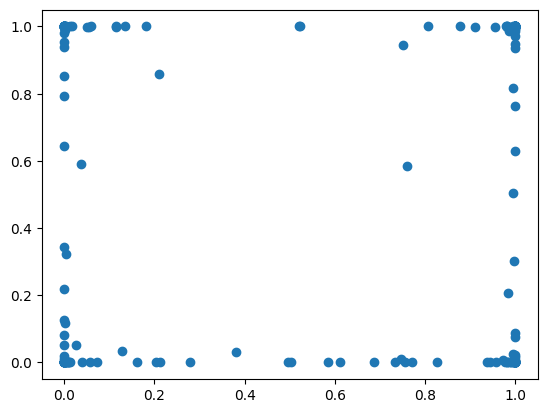

In [4]:
plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x3@beta_3).squeeze().cov()

In [5]:
train_x1

tensor([[ 1.1562e+00, -6.7676e-01, -2.9011e-02,  ..., -1.0559e+00,
         -1.4391e+00, -6.0677e-01],
        [-3.5220e-01,  1.6572e-01,  1.4609e+00,  ..., -1.6776e+00,
         -1.3760e-03,  7.8600e-01],
        [ 9.6538e-01, -3.3180e-01,  1.0211e+00,  ..., -1.2069e-01,
         -1.0751e+00, -3.9528e-01],
        ...,
        [-1.0532e+00,  2.7305e-01,  3.2043e-01,  ...,  2.4501e+00,
         -4.6602e-02, -4.2758e-01],
        [ 2.1007e-01, -4.2998e-02,  1.1864e+00,  ...,  6.7503e-01,
         -8.6875e-01,  4.5822e-01],
        [ 6.1372e-01, -8.2253e-02, -1.4422e-01,  ...,  6.7524e-01,
          2.2452e-02, -8.7104e-01]])

In [6]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [38]:
################## first step##################

# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2 = config["lambda1"], config["lambda2"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=2)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=30)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_a98c3_00000,TERMINATED,10.224.0.12:3529,0.02,0.001,1,11.8294,1.71753
train_model_a98c3_00001,TERMINATED,10.224.0.12:3917,0.01,0.002,1,11.6698,1.72515
train_model_a98c3_00002,TERMINATED,10.224.0.12:3920,0.01,0.002,1,11.8468,1.72515
train_model_a98c3_00003,TERMINATED,10.224.0.12:3921,0.01,0.002,1,11.1127,1.72515
train_model_a98c3_00004,TERMINATED,10.224.0.12:3923,0.02,0.002,1,11.557,1.62314
train_model_a98c3_00005,TERMINATED,10.224.0.12:3925,0.03,0.002,1,11.0803,1.49014
train_model_a98c3_00006,TERMINATED,10.224.0.12:3927,0.04,0.001,1,11.1194,1.31623
train_model_a98c3_00007,TERMINATED,10.224.0.12:3929,0.01,0.001,1,10.9746,1.86382
train_model_a98c3_00008,TERMINATED,10.224.0.12:3932,0.05,0.001,1,11.4544,1.12191
train_model_a98c3_00009,TERMINATED,10.224.0.12:3934,0.05,0.002,1,11.1823,1.10631


Result for train_model_a98c3_00000:
  date: 2022-10-12_18-57-42
  done: false
  experiment_id: eb5429ff02c14585b9d8fc73356522d4
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7175273895263672
  node_ip: 10.224.0.12
  pid: 3529
  time_since_restore: 11.829413890838623
  time_this_iter_s: 11.829413890838623
  time_total_s: 11.829413890838623
  timestamp: 1665572262
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a98c3_00000
  warmup_time: 0.003869771957397461
  
Result for train_model_a98c3_00000:
  date: 2022-10-12_18-57-42
  done: true
  experiment_id: eb5429ff02c14585b9d8fc73356522d4
  experiment_tag: 0_lambda1=0.0200,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7175273895263672
  node_ip: 10.224.0.12
  pid: 3529
  time_since_restore: 11.829413890838623
  time_this_iter_s: 11.829413890838623
  time_total_s: 11.829413890838623
  timestamp: 1665572262
  timesteps_since_restore: 0


Result for train_model_a98c3_00019:
  date: 2022-10-12_18-57-45
  done: false
  experiment_id: 616b3850ca574703bce9e6faed37fe27
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3162337064743042
  node_ip: 10.224.0.12
  pid: 3952
  time_since_restore: 11.227242708206177
  time_this_iter_s: 11.227242708206177
  time_total_s: 11.227242708206177
  timestamp: 1665572265
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a98c3_00019
  warmup_time: 0.004260063171386719
  
Result for train_model_a98c3_00019:
  date: 2022-10-12_18-57-45
  done: true
  experiment_id: 616b3850ca574703bce9e6faed37fe27
  experiment_tag: 19_lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3162337064743042
  node_ip: 10.224.0.12
  pid: 3952
  time_since_restore: 11.227242708206177
  time_this_iter_s: 11.227242708206177
  time_total_s: 11.227242708206177
  timestamp: 1665572265
  timesteps_since_restore: 0

Result for train_model_a98c3_00018:
  date: 2022-10-12_18-57-46
  done: false
  experiment_id: d7495a14884344d9b106426f103c57cf
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3162337064743042
  node_ip: 10.224.0.12
  pid: 3951
  time_since_restore: 11.852218627929688
  time_this_iter_s: 11.852218627929688
  time_total_s: 11.852218627929688
  timestamp: 1665572266
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a98c3_00018
  warmup_time: 0.004767894744873047
  
Result for train_model_a98c3_00018:
  date: 2022-10-12_18-57-46
  done: true
  experiment_id: d7495a14884344d9b106426f103c57cf
  experiment_tag: 18_lambda1=0.0400,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3162337064743042
  node_ip: 10.224.0.12
  pid: 3951
  time_since_restore: 11.852218627929688
  time_this_iter_s: 11.852218627929688
  time_total_s: 11.852218627929688
  timestamp: 1665572266
  timesteps_since_restore: 0

2022-10-12 18:57:47,049	INFO tune.py:758 -- Total run time: 18.83 seconds (18.64 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
a98c3_00000          1.717527         11.829414  True            None   
a98c3_00001          1.725146         11.669804  True            None   
a98c3_00002          1.725146         11.846753  True            None   
a98c3_00003          1.725146         11.112718  True            None   
a98c3_00004          1.623138         11.556973  True            None   
a98c3_00005          1.490140         11.080322  True            None   
a98c3_00006          1.316234         11.119438  True            None   
a98c3_00007          1.863820         10.974620  True            None   
a98c3_00008          1.121907         11.454391  True            None   
a98c3_00009          1.106313         11.182295  True            None   
a98c3_00010          1.572832         11.522146  True            N

In [39]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.1063130140304565


{'lambda1': 0.05, 'lambda2': 0.002}

In [40]:
################## second step##################

#0.4,0.4
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
lambda1,lambda2=final_lambda["lambda1"],final_lambda["lambda2"]
learning_rate=0.8
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(1.7886)

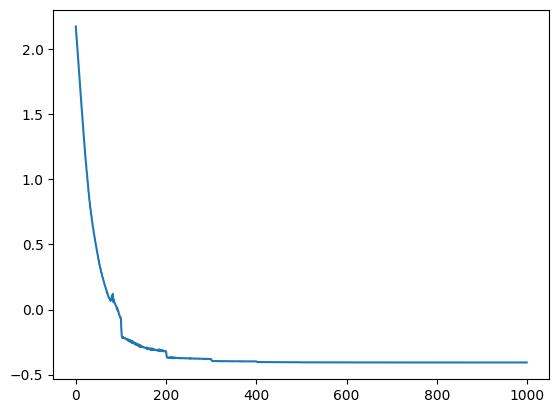

In [43]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [44]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(1.7886)

tensor(0.1159)

tensor(0.0080)

tensor(1.6647)

In [45]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[89,  1],
       [ 1, 69]])

array([[88,  0],
       [ 0, 72]])

array([[67,  2],
       [ 1, 90]])

In [46]:
################## third step##################

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta = config["lambda1"], config["lambda2"],config["eta"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=2)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=0.8
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
#         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, targets_1[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, targets_1[idx_test].reshape(-1,1))

        test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
    }

    result = tune.run(
        train_model,  
        config=config,
        num_samples=96)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,iter,total time (s),my_test_BCE_loss
train_model_e37d4_00000,TERMINATED,10.224.0.12:5173,0.75,0.04,0.003,1,14.5224,1.41804
train_model_e37d4_00001,TERMINATED,10.224.0.12:5204,0.35,0.05,0.002,1,14.1433,1.24045
train_model_e37d4_00002,TERMINATED,10.224.0.12:5206,0.09,0.04,0.001,1,14.3954,1.34063
train_model_e37d4_00003,TERMINATED,10.224.0.12:5208,0.55,0.05,0.002,1,14.3059,1.33882
train_model_e37d4_00004,TERMINATED,10.224.0.12:5210,0.12,0.04,0.002,1,14.2589,1.28122
train_model_e37d4_00005,TERMINATED,10.224.0.12:5212,0.95,0.05,0.001,1,15.983,1.52512
train_model_e37d4_00006,TERMINATED,10.224.0.12:5214,0.95,0.05,0.003,1,14.4207,1.53517
train_model_e37d4_00007,TERMINATED,10.224.0.12:5216,0.45,0.05,0.001,1,15.5203,1.26017
train_model_e37d4_00008,TERMINATED,10.224.0.12:5218,0.65,0.04,0.003,1,15.5633,1.43534
train_model_e37d4_00009,TERMINATED,10.224.0.12:5220,0.12,0.04,0.003,1,15.7608,1.23904


Result for train_model_e37d4_00000:
  date: 2022-10-12_18-59-22
  done: false
  experiment_id: a256d22bf61e4052b4bb49ce1215b412
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4180398464202881
  node_ip: 10.224.0.12
  pid: 5173
  time_since_restore: 14.522373914718628
  time_this_iter_s: 14.522373914718628
  time_total_s: 14.522373914718628
  timestamp: 1665572362
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00000
  warmup_time: 0.003499746322631836
  
Result for train_model_e37d4_00000:
  date: 2022-10-12_18-59-22
  done: true
  experiment_id: a256d22bf61e4052b4bb49ce1215b412
  experiment_tag: 0_eta=0.7500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4180398464202881
  node_ip: 10.224.0.12
  pid: 5173
  time_since_restore: 14.522373914718628
  time_this_iter_s: 14.522373914718628
  time_total_s: 14.522373914718628
  timestamp: 1665572362
  timesteps_since_

Result for train_model_e37d4_00025:
  date: 2022-10-12_18-59-25
  done: false
  experiment_id: 44e541b66241470fb9588daf6bd6f41f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3045122981071473
  node_ip: 10.224.0.12
  pid: 5253
  time_since_restore: 14.423074960708618
  time_this_iter_s: 14.423074960708618
  time_total_s: 14.423074960708618
  timestamp: 1665572365
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00025
  warmup_time: 0.008466005325317383
  
Result for train_model_e37d4_00025:
  date: 2022-10-12_18-59-25
  done: true
  experiment_id: 44e541b66241470fb9588daf6bd6f41f
  experiment_tag: 25_eta=0.5500,lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3045122981071473
  node_ip: 10.224.0.12
  pid: 5253
  time_since_restore: 14.423074960708618
  time_this_iter_s: 14.423074960708618
  time_total_s: 14.423074960708618
  timestamp: 1665572365
  timesteps_since

Result for train_model_e37d4_00029:
  date: 2022-10-12_18-59-26
  done: false
  experiment_id: 9a7158e4d71f4c6db8f139e22e69efe7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2213274598121644
  node_ip: 10.224.0.12
  pid: 5261
  time_since_restore: 14.833024740219116
  time_this_iter_s: 14.833024740219116
  time_total_s: 14.833024740219116
  timestamp: 1665572366
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00029
  warmup_time: 0.005033254623413086
  
Result for train_model_e37d4_00029:
  date: 2022-10-12_18-59-26
  done: true
  experiment_id: 9a7158e4d71f4c6db8f139e22e69efe7
  experiment_tag: 29_eta=0.1500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2213274598121644
  node_ip: 10.224.0.12
  pid: 5261
  time_since_restore: 14.833024740219116
  time_this_iter_s: 14.833024740219116
  time_total_s: 14.833024740219116
  timestamp: 1665572366
  timesteps_since

Result for train_model_e37d4_00010:
  date: 2022-10-12_18-59-27
  done: false
  experiment_id: 592b2f5106194474834d5a65fbd8c9c8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2915988445281983
  node_ip: 10.224.0.12
  pid: 5222
  time_since_restore: 16.239744186401367
  time_this_iter_s: 16.239744186401367
  time_total_s: 16.239744186401367
  timestamp: 1665572367
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00010
  warmup_time: 0.012369871139526367
  
Result for train_model_e37d4_00028:
  date: 2022-10-12_18-59-27
  done: false
  experiment_id: 76fa42b434724047b64cb6e35871268f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.26487877368927
  node_ip: 10.224.0.12
  pid: 5259
  time_since_restore: 15.806171655654907
  time_this_iter_s: 15.806171655654907
  time_total_s: 15.806171655654907
  timestamp: 1665572367
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00028
  w

Result for train_model_e37d4_00039:
  date: 2022-10-12_18-59-40
  done: false
  experiment_id: 1314a6fe033645819524f98646329e7a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.435342288017273
  node_ip: 10.224.0.12
  pid: 5232
  time_since_restore: 14.765044450759888
  time_this_iter_s: 14.765044450759888
  time_total_s: 14.765044450759888
  timestamp: 1665572380
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00039
  warmup_time: 0.0041735172271728516
  
Result for train_model_e37d4_00039:
  date: 2022-10-12_18-59-40
  done: true
  experiment_id: 1314a6fe033645819524f98646329e7a
  experiment_tag: 39_eta=0.6500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.435342288017273
  node_ip: 10.224.0.12
  pid: 5232
  time_since_restore: 14.765044450759888
  time_this_iter_s: 14.765044450759888
  time_total_s: 14.765044450759888
  timestamp: 1665572380
  timesteps_since_

Result for train_model_e37d4_00056:
  date: 2022-10-12_18-59-41
  done: false
  experiment_id: 675d59cf55a147598427d39ddba2cef8
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.254513108730316
  node_ip: 10.224.0.12
  pid: 5247
  time_since_restore: 14.601318120956421
  time_this_iter_s: 14.601318120956421
  time_total_s: 14.601318120956421
  timestamp: 1665572381
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00056
  warmup_time: 0.004450082778930664
  
Result for train_model_e37d4_00056:
  date: 2022-10-12_18-59-41
  done: true
  experiment_id: 675d59cf55a147598427d39ddba2cef8
  experiment_tag: 56_eta=0.1000,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.254513108730316
  node_ip: 10.224.0.12
  pid: 5247
  time_since_restore: 14.601318120956421
  time_this_iter_s: 14.601318120956421
  time_total_s: 14.601318120956421
  timestamp: 1665572381
  timesteps_since_r

Result for train_model_e37d4_00060:
  date: 2022-10-12_18-59-42
  done: false
  experiment_id: 111a1109257e43798c93127e05fdd5ad
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2888131141662598
  node_ip: 10.224.0.12
  pid: 5212
  time_since_restore: 15.09417724609375
  time_this_iter_s: 15.09417724609375
  time_total_s: 15.09417724609375
  timestamp: 1665572382
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00060
  warmup_time: 0.004323482513427734
  
Result for train_model_e37d4_00046:
  date: 2022-10-12_18-59-42
  done: false
  experiment_id: 57e1030a9684483599eb16e2563238df
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2812156438827516
  node_ip: 10.224.0.12
  pid: 5249
  time_since_restore: 16.024190187454224
  time_this_iter_s: 16.024190187454224
  time_total_s: 16.024190187454224
  timestamp: 1665572382
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00046
  wa

Result for train_model_e37d4_00065:
  date: 2022-10-12_18-59-54
  done: true
  experiment_id: 1b1c59074f5749e995354deddfd7cd90
  experiment_tag: 65_eta=0.5500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.3287895679473878
  node_ip: 10.224.0.12
  pid: 5224
  time_since_restore: 14.883076906204224
  time_this_iter_s: 14.883076906204224
  time_total_s: 14.883076906204224
  timestamp: 1665572394
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00065
  warmup_time: 0.009036779403686523
  
Result for train_model_e37d4_00067:
  date: 2022-10-12_18-59-54
  done: false
  experiment_id: 6d3ec8458cf24fb09454406652c8157d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5337050437927247
  node_ip: 10.224.0.12
  pid: 5210
  time_since_restore: 15.044041872024536
  time_this_iter_s: 15.044041872024536
  time_total_s: 15.044041872024536
  timestamp: 1665572394
  timesteps_since

Result for train_model_e37d4_00070:
  date: 2022-10-12_18-59-55
  done: false
  experiment_id: 1314a6fe033645819524f98646329e7a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2357112407684325
  node_ip: 10.224.0.12
  pid: 5232
  time_since_restore: 15.406047582626343
  time_this_iter_s: 15.406047582626343
  time_total_s: 15.406047582626343
  timestamp: 1665572395
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00070
  warmup_time: 0.0041735172271728516
  
Result for train_model_e37d4_00070:
  date: 2022-10-12_18-59-55
  done: true
  experiment_id: 1314a6fe033645819524f98646329e7a
  experiment_tag: 70_eta=0.2500,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2357112407684325
  node_ip: 10.224.0.12
  pid: 5232
  time_since_restore: 15.406047582626343
  time_this_iter_s: 15.406047582626343
  time_total_s: 15.406047582626343
  timestamp: 1665572395
  timesteps_sinc

Result for train_model_e37d4_00081:
  date: 2022-10-12_18-59-56
  done: false
  experiment_id: d2a6cf6cb8d24f7da8dfcd53a52b935a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.211661970615387
  node_ip: 10.224.0.12
  pid: 5245
  time_since_restore: 15.003240823745728
  time_this_iter_s: 15.003240823745728
  time_total_s: 15.003240823745728
  timestamp: 1665572396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00081
  warmup_time: 0.009243011474609375
  
Result for train_model_e37d4_00081:
  date: 2022-10-12_18-59-56
  done: true
  experiment_id: d2a6cf6cb8d24f7da8dfcd53a52b935a
  experiment_tag: 81_eta=0.1500,lambda1=0.0500,lambda2=0.0010
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.211661970615387
  node_ip: 10.224.0.12
  pid: 5245
  time_since_restore: 15.003240823745728
  time_this_iter_s: 15.003240823745728
  time_total_s: 15.003240823745728
  timestamp: 1665572396
  timesteps_since_r

Result for train_model_e37d4_00094:
  date: 2022-10-12_18-59-57
  done: false
  experiment_id: 9916278b5b1e4d68bfa22f6ebe8d2207
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2779215812683105
  node_ip: 10.224.0.12
  pid: 5218
  time_since_restore: 14.361762285232544
  time_this_iter_s: 14.361762285232544
  time_total_s: 14.361762285232544
  timestamp: 1665572397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e37d4_00094
  warmup_time: 0.009513378143310547
  
Result for train_model_e37d4_00094:
  date: 2022-10-12_18-59-57
  done: true
  experiment_id: 9916278b5b1e4d68bfa22f6ebe8d2207
  experiment_tag: 94_eta=0.0900,lambda1=0.0400,lambda2=0.0030
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.2779215812683105
  node_ip: 10.224.0.12
  pid: 5218
  time_since_restore: 14.361762285232544
  time_this_iter_s: 14.361762285232544
  time_total_s: 14.361762285232544
  timestamp: 1665572397
  timesteps_since

2022-10-12 19:00:03,782	INFO tune.py:758 -- Total run time: 58.35 seconds (58.01 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
e37d4_00000          1.418040         14.522374  True            None   
e37d4_00001          1.240446         14.143335  True            None   
e37d4_00002          1.340626         14.395445  True            None   
e37d4_00003          1.338825         14.305942  True            None   
e37d4_00004          1.281216         14.258863  True            None   
...                       ...               ...   ...             ...   
e37d4_00095          1.201375         14.380238  True            None   
e37d4_00096          1.501146         10.196758  True            None   
e37d4_00097          1.283830          8.948696  True            None   
e37d4_00098          1.254513          8.403400  True            None   
e37d4_00099          1.579535          8.798383  True            N

In [47]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
final_parameter

Best trial final validation loss: 1.1562719702720643


{'lambda1': 0.05, 'lambda2': 0.002, 'eta': 0.17}

In [48]:
################## second step##################

#no prior
prior=0

#0.4,0.4
# set hyperparamters
final_parameter=result.get_best_config('my_test_BCE_loss',mode='min')
# lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
lambda1,lambda2,eta=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"]
learning_rate=0.8
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.4929, grad_fn=<AddBackward0>)

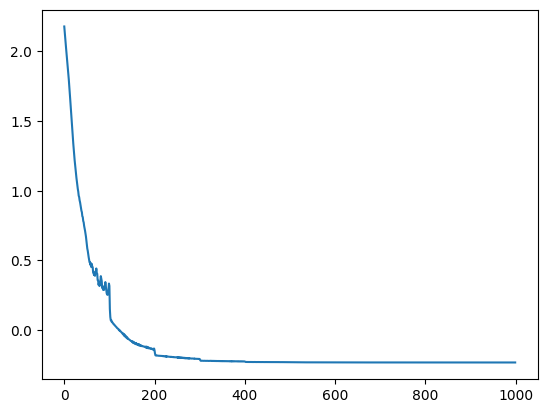

In [49]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [50]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.1158e-01, -1.4509e-01, -2.0189e-01, -1.1023e-01, -1.8575e-01,
         -1.9053e-01, -1.3710e-01, -1.1982e-01, -1.7109e-01, -1.3094e-01,
         -1.8835e-06, -1.3361e-02,  3.5876e-06,  1.6304e-03,  6.7502e-07,
         -2.8635e-07, -1.1505e-06,  2.6821e-06, -2.3676e-06, -1.1806e-06,
         -2.8008e-06,  2.3120e-06, -5.9821e-07, -8.3336e-07,  1.3727e-06,
          2.8293e-07, -2.2851e-06,  1.7334e-06, -4.2246e-06,  1.4497e-06,
         -4.1662e-07,  2.6291e-06,  4.0056e-07,  2.3821e-06,  1.6147e-06,
          1.4024e-07,  2.4506e-06,  1.0492e-06,  1.3077e-06,  8.3439e-07,
         -5.6198e-07, -2.8344e-06,  1.0724e-06, -3.0034e-06, -2.0577e-06,
         -1.5895e-06, -1.4656e-07, -5.0801e-07,  1.1400e-06,  1.9448e-07,
         -3.2165e-06, -7.4005e-07, -4.2128e-07, -8.0083e-07, -2.6525e-06,
         -1.7568e-06,  1.7642e-06,  2.8670e-06, -2.1525e-06, -1.1821e-06,
         -4.5389e-07,  6.9999e-07,  5.0594e-07,  8.3353e-07,  2.8470e-06,
         -2.9121e-06,  1.9219e-06, -1.

tensor([[-1.1158e-01, -1.4509e-01, -2.0189e-01, -1.1023e-01, -1.8575e-01,
         -1.9053e-01, -1.3710e-01, -1.1982e-01, -1.7109e-01, -1.3094e-01,
         -1.8835e-06, -1.3361e-02,  3.5876e-06,  1.6304e-03,  6.7502e-07,
         -2.8635e-07, -1.1505e-06,  2.6821e-06, -2.3676e-06, -1.1806e-06,
         -2.8008e-06,  2.3120e-06, -5.9821e-07, -8.3336e-07,  1.3727e-06,
          2.8293e-07, -2.2851e-06,  1.7334e-06, -4.2246e-06,  1.4497e-06,
         -4.1662e-07,  2.6291e-06,  4.0056e-07,  2.3821e-06,  1.6147e-06,
          1.4024e-07,  2.4506e-06,  1.0492e-06,  1.3077e-06,  8.3439e-07,
         -5.6198e-07, -2.8344e-06,  1.0724e-06, -3.0034e-06, -2.0577e-06,
         -1.5895e-06, -1.4656e-07, -5.0801e-07,  1.1400e-06,  1.9448e-07,
         -3.2165e-06, -7.4005e-07, -4.2128e-07, -8.0083e-07, -2.6525e-06,
         -1.7568e-06,  1.7642e-06,  2.8670e-06, -2.1525e-06, -1.1821e-06,
         -4.5389e-07,  6.9999e-07,  5.0594e-07,  8.3353e-07,  2.8470e-06,
         -2.9121e-06,  1.9219e-06, -1.

tensor([[-1.2488e-01,  1.9619e-01, -2.1023e-01, -1.4491e-01,  1.7533e-01,
         -2.2424e-01, -1.5368e-01, -1.3022e-01, -1.7036e-01, -1.8005e-01,
         -4.8721e-07,  3.8461e-04, -1.9425e-07,  3.2189e-02,  3.1443e-08,
         -1.6068e-08,  1.0371e-07, -4.7576e-07,  1.1719e-07, -1.9419e-06,
          3.2157e-07,  2.3849e-07, -1.8608e-08, -2.5406e-07,  1.6890e-06,
         -3.4392e-08, -4.2840e-07, -1.0791e-06, -5.1621e-08,  5.6851e-08,
         -5.2100e-08,  8.3804e-08,  4.5274e-08,  2.0707e-08,  1.0185e-06,
         -2.8430e-07,  1.1542e-07, -9.5750e-08,  5.6721e-07, -2.8394e-07,
          1.0269e-07,  2.0391e-08, -3.7295e-08,  4.0879e-09, -3.9771e-07,
         -5.9599e-07, -1.3559e-07, -1.6188e-08, -2.2929e-06, -3.5037e-08,
         -1.8074e-07, -1.1801e-08,  9.3760e-07,  3.6204e-07,  9.4720e-07,
         -1.1926e-06,  1.1423e-06, -4.2580e-08, -4.1470e-07, -5.9334e-07,
          2.2443e-07,  6.6228e-08, -2.4124e-06, -4.0844e-08,  4.8228e-08,
          5.8222e-07,  1.4808e-07, -4.

In [51]:

model_1(test_x1)[0].squeeze()
model_2(test_x2)[0].squeeze()
model_3(test_x3)[0].squeeze()


tensor([9.8107e-01, 9.8336e-01, 1.9745e-01, 6.2667e-01, 1.3760e-03, 9.8226e-01,
        9.3099e-01, 6.6403e-02, 9.7746e-01, 8.2240e-01, 1.3318e-05, 9.7754e-01,
        9.8812e-01, 1.6354e-02, 4.8205e-01, 9.6210e-01, 9.2210e-02, 9.1539e-01,
        1.8805e-02, 5.4413e-03, 3.8275e-03, 9.7209e-01, 9.4900e-01, 4.9656e-01,
        7.4315e-01, 2.4915e-01, 1.9945e-01, 2.1852e-02, 5.1361e-01, 3.2639e-01,
        1.7187e-01, 1.6514e-01, 1.5206e-03, 4.8773e-01, 1.4913e-01, 7.9084e-01,
        9.1936e-01, 9.3780e-01, 2.7666e-01, 7.6343e-04],
       grad_fn=<SqueezeBackward0>)

tensor([3.6056e-03, 9.9989e-01, 9.8998e-01, 9.8323e-01, 8.8478e-01, 9.9907e-01,
        9.8939e-01, 9.9874e-01, 2.1545e-02, 1.7288e-04, 9.3397e-02, 9.9238e-01,
        2.9275e-04, 9.7681e-01, 2.0102e-01, 9.3263e-01, 9.8782e-01, 9.9381e-01,
        3.0996e-02, 9.9823e-01, 9.9286e-01, 3.3902e-01, 2.0209e-02, 9.0302e-04,
        9.5402e-01, 2.5455e-04, 6.8335e-01, 2.2983e-02, 4.5681e-02, 1.0625e-01,
        9.9272e-01, 9.9470e-01, 7.7454e-01, 5.3312e-01, 9.9914e-01, 9.9700e-01,
        9.9917e-01, 5.6116e-03, 9.9902e-01, 9.8507e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0.3985, 0.9189, 0.9126, 0.9125, 0.0847, 0.3439, 0.5848, 0.2843, 0.9077,
        0.7915, 0.8367, 0.0872, 0.9244, 0.4179, 0.9225, 0.2151, 0.9241, 0.9073,
        0.8247, 0.9232, 0.6479, 0.5236, 0.6962, 0.7392, 0.2826, 0.0456, 0.0427,
        0.9154, 0.5864, 0.9144, 0.7317, 0.0258, 0.8259, 0.8606, 0.0529, 0.1591,
        0.4051, 0.6601, 0.4621, 0.2174], grad_fn=<SqueezeBackward0>)

In [52]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[44,  7],
       [ 9, 60]])

0.8695652173913043

0.8627450980392157

0.8666666666666667

0.8955223880597015

0.8823529411764706

In [53]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[18,  0],
       [ 4, 18]])

0.8181818181818182

1.0

array([[11,  4],
       [ 4, 21]])

0.84

0.7333333333333333

array([[15,  3],
       [ 1, 21]])

0.9545454545454546

0.8333333333333334

(raylet) [2022-10-12 20:34:48,531 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1469734912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:34:58,539 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1469624320; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:35:08,546 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1469509632; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:35:18,553 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1469378560; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 20:39:58,739 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1461821440; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:08,743 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1461592064; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:18,747 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1460314112; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:40:28,752 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1459920896; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 20:45:08,909 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1439637504; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:18,913 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1439100928; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:28,920 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1438990336; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-10-12 20:45:38,927 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1438883840; capacity: 29394726912. Object creation will fail i

(raylet) [2022-10-12 20:50:19,126 E 22371 22389] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-10-12_18-01-04_663864_7028 is over 95% full, available space: 1435086848; capacity: 29394726912. Object creation will fail if spilling is required.


In [45]:
prediction_3.squeeze()
target_3.squeeze()

tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0], dtype=torch.int32)

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [46]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.14127152e-01, -1.59997821e-01, -2.08835661e-01,
        -1.13469869e-01, -2.05941767e-01, -1.96102679e-01,
        -1.45482913e-01, -1.24484845e-01, -1.93076611e-01,
         1.64480031e-01, -1.84582711e-06, -7.33565679e-03,
        -4.86781744e-07,  3.78320366e-03,  2.54662018e-06,
        -8.23811149e-07, -1.21015660e-06, -1.34006223e-06,
         1.50352821e-06,  2.17897252e-07, -2.56844942e-06,
         1.98862335e-06, -4.62323470e-07,  2.67930864e-06,
         1.36442111e-06, -2.88046704e-06, -2.02555907e-06,
         1.43033390e-06, -4.05695164e-06, -4.33513151e-07,
         2.78624316e-06,  2.26949783e-06,  8.41118549e-07,
         3.17534295e-06,  1.87691273e-06, -6.45157570e-07,
        -1.76296999e-06, -9.83863515e-07, -2.93038170e-06,
        -3.25865045e-07, -1.94985063e-07,  2.22624948e-07,
         6.97460450e-07,  1.02191211e-06,  1.75787625e-06,
        -1.44163721e-06, -3.32292575e-06, -2.83342160e-06,
         1.98365615e-06, -1.74928675e-06,  6.67002269e-0

array([[-1.14127152e-01, -1.59997821e-01, -2.08835661e-01,
        -1.13469869e-01, -2.05941767e-01, -1.96102679e-01,
        -1.45482913e-01, -1.24484845e-01, -1.93076611e-01,
         1.64480031e-01, -1.84582711e-06, -7.33565679e-03,
        -4.86781744e-07,  3.78320366e-03,  2.54662018e-06,
        -8.23811149e-07, -1.21015660e-06, -1.34006223e-06,
         1.50352821e-06,  2.17897252e-07, -2.56844942e-06,
         1.98862335e-06, -4.62323470e-07,  2.67930864e-06,
         1.36442111e-06, -2.88046704e-06, -2.02555907e-06,
         1.43033390e-06, -4.05695164e-06, -4.33513151e-07,
         2.78624316e-06,  2.26949783e-06,  8.41118549e-07,
         3.17534295e-06,  1.87691273e-06, -6.45157570e-07,
        -1.76296999e-06, -9.83863515e-07, -2.93038170e-06,
        -3.25865045e-07, -1.94985063e-07,  2.22624948e-07,
         6.97460450e-07,  1.02191211e-06,  1.75787625e-06,
        -1.44163721e-06, -3.32292575e-06, -2.83342160e-06,
         1.98365615e-06, -1.74928675e-06,  6.67002269e-0

array([[-1.14127152e-01, -1.59997821e-01, -2.08835661e-01,
        -1.13469869e-01, -2.05941767e-01, -1.96102679e-01,
        -1.45482913e-01, -1.24484845e-01, -1.93076611e-01,
         1.64480031e-01, -1.84582711e-06, -7.33565679e-03,
        -4.86781744e-07,  3.78320366e-03,  2.54662018e-06,
        -8.23811149e-07, -1.21015660e-06, -1.34006223e-06,
         1.50352821e-06,  2.17897252e-07, -2.56844942e-06,
         1.98862335e-06, -4.62323470e-07,  2.67930864e-06,
         1.36442111e-06, -2.88046704e-06, -2.02555907e-06,
         1.43033390e-06, -4.05695164e-06, -4.33513151e-07,
         2.78624316e-06,  2.26949783e-06,  8.41118549e-07,
         3.17534295e-06,  1.87691273e-06, -6.45157570e-07,
        -1.76296999e-06, -9.83863515e-07, -2.93038170e-06,
        -3.25865045e-07, -1.94985063e-07,  2.22624948e-07,
         6.97460450e-07,  1.02191211e-06,  1.75787625e-06,
        -1.44163721e-06, -3.32292575e-06, -2.83342160e-06,
         1.98365615e-06, -1.74928675e-06,  6.67002269e-0

In [48]:
threshold=0.1
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.11412715, -0.15999782, -0.20883566, -0.11346987, -0.20594177,
        -0.19610268, -0.14548291, -0.12448484, -0.19307661,  0.16448003,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 71])

11